# Sarcasm Detection on SARC_v2 dataset using RoBERTa

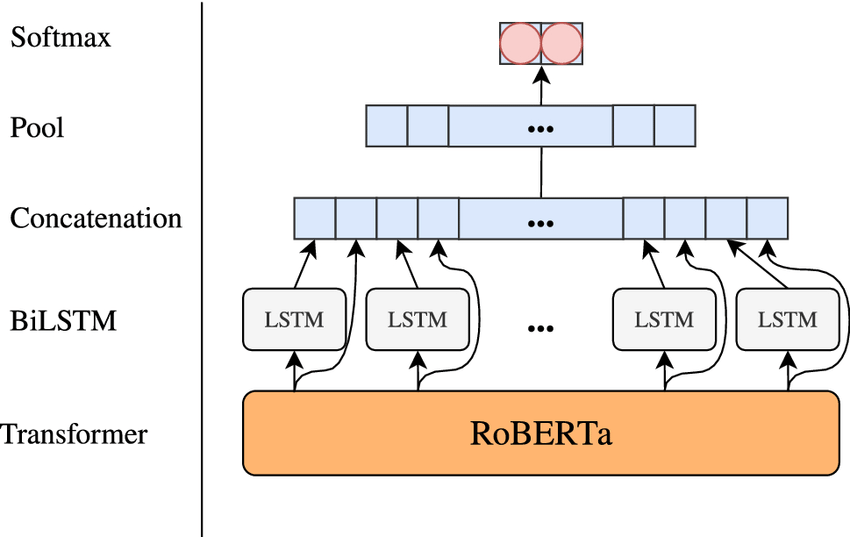

### Prepare Dataset
 * Go to https://drive.google.com/drive/folders/1dzF__PeMXuGq29NSbLbvvHV5hE6dlz5J?usp=sharing
 * Download train-balanced-sarcasm.csv
 * In Google Drive, create a folder named `Sarcasm_Detection` and keep the sarcasm_v2 folder inside that.
 * The path for the dataset should be `drive/My Drive/Sarcasm_Detection/sarcasm_v2/`

*Notes:*
* The original SARC dataset: https://nlp.cs.princeton.edu/old/SARC/2.0/main/
* Pre-processed and clean dataset (collected): https://www.kaggle.com/datasets/danofer/sarcasm?resource=download&select=train-balanced-sarcasm.csv (large)
* Small sarcasm v2 dataset: `sarcasm_v2/*` https://nlds.soe.ucsc.edu/sarcasm2

In [1]:
import warnings
warnings.filterwarnings("ignore")

#### Install dependencies

In [2]:
! pip install transformers

##### Load dataset from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Datasets
* We can use 4 datasets. To change a dataset we just have to replace the SARC_dataset_path string to the corresponding dataset path.
* First make sure, you download https://drive.google.com/drive/folders/1dzF__PeMXuGq29NSbLbvvHV5hE6dlz5J?usp=sharing the `Sarcasm_Detection` folder and upload to your Google drive.

*The datasets are:*
 * `SARC_dataset_path = "drive/My Drive/Sarcasm_Detection/sarcasm_v2/GEN-sarc-notsarc.csv"`
 * `SARC_dataset_path = "drive/My Drive/Sarcasm_Detection/sarcasm_v2/HYP-sarc-notsarc.csv"`
 * `SARC_dataset_path = "drive/My Drive/Sarcasm_Detection/sarcasm_v2/RQ-sarc-notsarc.csv"`
 * `SARC_dataset_path = "drive/My Drive/Sarcasm_Detection/train-balanced-sarcasm.csv"`

In [6]:
SARC_dataset_path = "drive/My Drive/GEN-sarc-notsarc.csv"

In [7]:
import pandas as pd
SARC_df = pd.read_csv(SARC_dataset_path)

In [8]:
SARC_df.head()

,class,id,text
0,notsarc,1,"If that's true, then Freedom of Speech is doom..."
1,notsarc,2,Neener neener - is it time to go in from the p...
2,notsarc,3,"Just like the plastic gun fear, the armour pie..."
3,notsarc,4,So geology is a religion because we weren't he...
4,notsarc,5,Well done Monty. Mark that up as your first ev...


* We are only looking at `text`, and `class` column.
* (train sentences, and groundtruth)

In [10]:
set(SARC_df['class'])

{'notsarc', 'sarc'}

In [11]:
dataset_x = SARC_df['text']
dataset_y = SARC_df['class']

In [12]:
dataset_y.replace({'notsarc': 0, 'sarc': 1}, inplace = True)

In [13]:
dataset_y

0       0
1       0
2       0
3       0
4       0
       ..
6515    1
6516    1
6517    1
6518    1
6519    1
Name: class, Length: 6520, dtype: int64

In [14]:
from collections import Counter
Counter(dataset_y)

Counter({0: 3260, 1: 3260})

 * 75% data for training and 25% for testing / validation / evaluation.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.25, random_state=42)

In [16]:
X_train, X_test, y_train, y_test = list(X_train), list(X_test), list(y_train), list(y_test)

In [17]:
print(len(X_train))
print(len(X_test))

4890
1630


 * For tokenizing text to numbers / tokens, we are just going to use **BertTokenizer**.

### Introduction
Tokenization is one of the first step in any NLP pipeline. Tokenization is nothing but splitting the raw text into small chunks of words or sentences, called tokens. If the text is split into words, then its called as 'Word Tokenization' and if it's split into sentences then its called as 'Sentence Tokenization'. Generally 'space' is used to perform the word tokenization and characters like 'periods, exclamation point and newline char are used for Sentence Tokenization. We have to choose the appropriate method as per the task in hand. While performing the tokenization few characters like spaces, punctuations are ignored and will not be the part of final list of tokens.

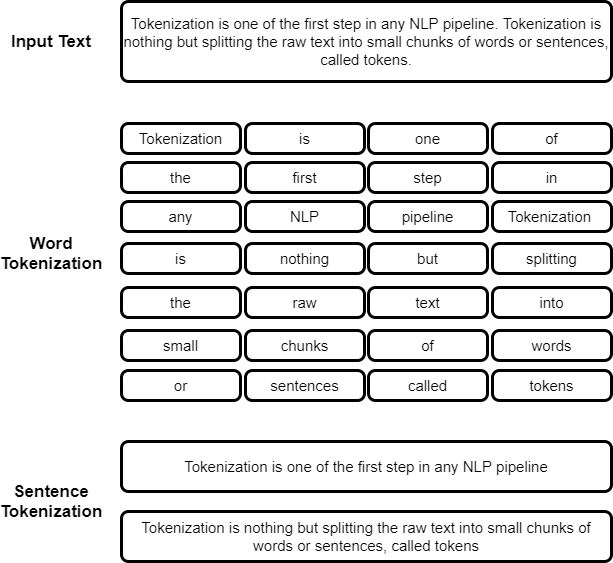

### Why Tokenization is Required?

Every sentence gets its meaning by the words present in it. So by analyzing the words present in the text we can easily interpret the meaning of the text. Once we have a list of words we can also use statistical tools and methods to get more insights into the text. For example, we can use word count and word frequency to find out important of word in that sentence or document.

#### Summary of sentence length overall

In [18]:
import numpy as np
print(np.mean([len(x.split(' ')) for x in X_train]))
print(np.max([len(x.split(' ')) for x in X_train]))
print(np.min([len(x.split(' ')) for x in X_train]))

43.7398773006135
164
9


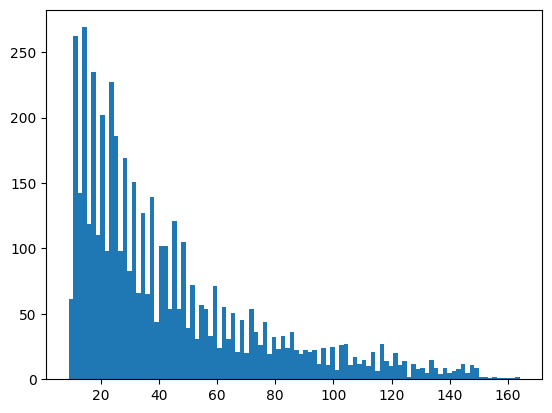

In [19]:
import matplotlib.pyplot as plt
plt.hist([len(x.split(' ')) for x in X_train], bins = 100)
plt.show()

### Drop all the sentences longer than 50

### Tutorials for text tokenization
* https://www.kaggle.com/code/satishgunjal/tokenization-in-nlp
* https://neptune.ai/blog/tokenization-in-nlp
* https://www.analyticsvidhya.com/blog/2021/09/an-explanatory-guide-to-bert-tokenizer/

In [20]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_token = tokenizer.texts_to_sequences(X_train)

vocab_size = len(tokenizer.word_index) + 1

In [21]:
print(vocab_size)

16032


In [22]:
print(X_train[0])
print(tokenizer.texts_to_sequences([X_train[0]]))

But what about the married couple who know right up front they do not intend to have children, don't even intend to try? Do we ban them from marriage to?
[[24, 26, 36, 1, 887, 835, 47, 52, 60, 68, 1657, 25, 29, 12, 2034, 2, 14, 271, 40, 78, 2034, 2, 236, 29, 34, 450, 63, 44, 158, 2]]


In [23]:
import torch
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_length = 50, padding_side = 'right')

input_ids = torch.tensor(tokenizer.encode(X_train[0], add_special_tokens=True, max_length = 50, pad_to_max_length = True, truncation=True)).unsqueeze(0)  # Batch size 1

In [24]:
print(X_train[0])
print(input_ids)

But what about the married couple who know right up front they do not intend to have children, don't even intend to try? Do we ban them from marriage to?
tensor([[  101,  2021,  2054,  2055,  1996,  2496,  3232,  2040,  2113,  2157,
          2039,  2392,  2027,  2079,  2025, 13566,  2000,  2031,  2336,  1010,
          2123,  1005,  1056,  2130, 13566,  2000,  3046,  1029,  2079,  2057,
          7221,  2068,  2013,  3510,  2000,  1029,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])


In [25]:
# we also need attention masks

encoded = tokenizer.encode_plus(X_train[0], add_special_tokens=True, max_length = 50, pad_to_max_length = True,
                                return_token_type_ids = False,
                                return_attention_mask = True, truncation=True)  # Batch size 1

In [26]:
print(encoded)

{'input_ids': [101, 2021, 2054, 2055, 1996, 2496, 3232, 2040, 2113, 2157, 2039, 2392, 2027, 2079, 2025, 13566, 2000, 2031, 2336, 1010, 2123, 1005, 1056, 2130, 13566, 2000, 3046, 1029, 2079, 2057, 7221, 2068, 2013, 3510, 2000, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


### Pre-trained RoBERTa for sequence classification

In [27]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
print(model)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

### SARCASM Dataloader

In [29]:
from torch.utils.data import Dataset
import numpy as np
import re
import nltk
import string

class SARCDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        texts = X

        texts = [self._preprocess(text) for text in texts]

        self._print_random_samples(texts)

        self.texts = [tokenizer(text, padding='max_length',
                                max_length=150,
                                truncation=True,
                                return_tensors="pt")
                      for text in texts]

        self.labels = y

    def _print_random_samples(self, texts):
        np.random.seed(42)
        random_entries = np.random.randint(0, len(texts), 5)

        for i in random_entries:
            print(f"Entry {i}: {texts[i]}")

        print()

    def _preprocess(self, text):
        text = self._remove_amp(text)
        text = self._remove_links(text)
        text = self._remove_hashes(text)
        text = self._remove_retweets(text)
        text = self._remove_mentions(text)
        text = self._remove_multiple_spaces(text)

        #text = self._lowercase(text)
        text = self._remove_punctuation(text)
        #text = self._remove_numbers(text)

        text_tokens = self._tokenize(text)
        text_tokens = self._stopword_filtering(text_tokens)
        #text_tokens = self._stemming(text_tokens)
        text = self._stitch_text_tokens_together(text_tokens)

        return text.strip()


    def _remove_amp(self, text):
        return text.replace("&amp;", " ")

    def _remove_mentions(self, text):
        return re.sub(r'(@.*?)[\s]', ' ', text)

    def _remove_multiple_spaces(self, text):
        return re.sub(r'\s+', ' ', text)

    def _remove_retweets(self, text):
        return re.sub(r'^RT[\s]+', ' ', text)

    def _remove_links(self, text):
        return re.sub(r'https?:\/\/[^\s\n\r]+', ' ', text)

    def _remove_hashes(self, text):
        return re.sub(r'#', ' ', text)

    def _stitch_text_tokens_together(self, text_tokens):
        return " ".join(text_tokens)

    def _tokenize(self, text):
        return nltk.word_tokenize(text, language="english")

    def _stopword_filtering(self, text_tokens):
        stop_words = nltk.corpus.stopwords.words('english')

        return [token for token in text_tokens if token not in stop_words]

    def _stemming(self, text_tokens):
        porter = nltk.stem.porter.PorterStemmer()
        return [porter.stem(token) for token in text_tokens]

    def _remove_numbers(self, text):
        return re.sub(r'\d+', ' ', text)

    def _lowercase(self, text):
        return text.lower()

    def _remove_punctuation(self, text):
        return ''.join(character for character in text if character not in string.punctuation)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        label = -1
        if hasattr(self, 'labels'):
            label = self.labels[idx]

        return text, label

#### Train Test Split

In [30]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
train_sarc = SARCDataset(X_train, y_train, tokenizer)

Entry 860: Whats matter Cant anybody KC afford 2 cars emoticonXWow
Entry 3772: Yes I believe matter personal individual freedom If purchased legally used commit crime harm comes handgun ownership I dont one I many guns If ban handguns whats stop banning shotguns even BB guns I dont believe nanny state taking away toys good Waxy
Entry 3092: Well theres grounds lawsuit Find group veterans get sue VA funded NRA take whole organization court charges violating federal standards
Entry 466: That interpretation fine except God says I WILL make helper suitable He hadnt made animals yet verse 18 created Adam verse 7
Entry 4426: You state woman comes first This seems absolute Why woman come first Is fully developed Is important child carrying



In [32]:
test_sarc = SARCDataset(X_test, y_test, tokenizer)

Entry 1126: Sure The outcome Heller vs DC Florida Shall Issue laws support statement According Brady logic helpless safer criminals
Entry 1459: Then thats far go thats fine Not science worshiper I simply dont automatically take type blanket statement automatically true What largely prompted thread happened last Tuesday 630 AM sixfigure weather forecaster scientist guy assured everyone watching pretty nice day ahead largely cloudy yet peeks sun slim chance spotty rain 2 hours later beginning widespread heavy rain three solid hours Unusual course scientific blunders concerning miles I imagine could blunders concerning hundreds thousands light years
Entry 860: So havent got answer question prove busted Thats OKas long see
Entry 1294: Its even worse He isnt asking info works I would supply gladly He claims already know wrong implies thinks knows But despite already knowing carbon dating still needs someone provide explanation present proof incorrect As Akbar says Its trap
Entry 1130: Perha

In [33]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_sarc, batch_size=8, shuffle=True, num_workers=0)
val_dataloader = DataLoader(test_sarc, batch_size=8, num_workers=0)

### RoBERTa for sarcasm classification

The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov. It is based on Google’s BERT model released in 2018.

It builds on BERT and modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

**The abstract from the paper is the following:**

Language model pretraining has led to significant performance gains but careful comparison between different approaches is challenging. Training is computationally expensive, often done on private datasets of different sizes, and, as we will show, hyperparameter choices have significant impact on the final results. We present a replication study of BERT pretraining (Devlin et al., 2019) that carefully measures the impact of many key hyperparameters and training data size. We find that BERT was significantly undertrained, and can match or exceed the performance of every model published after it. Our best model achieves state-of-the-art results on GLUE, RACE and SQuAD. These results highlight the importance of previously overlooked design choices, and raise questions about the source of recently reported improvements. We release our models and code.

In [34]:
from torch import nn

class SARCClassifier(nn.Module):
    def __init__(self, base_model):
        super(SARCClassifier, self).__init__()

        self.bert = base_model
        self.fc1 = nn.Linear(768, 32)
        self.fc2 = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids,
                             attention_mask=attention_mask)[0][:, 0]
        x = self.fc1(bert_out)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

#### Training code

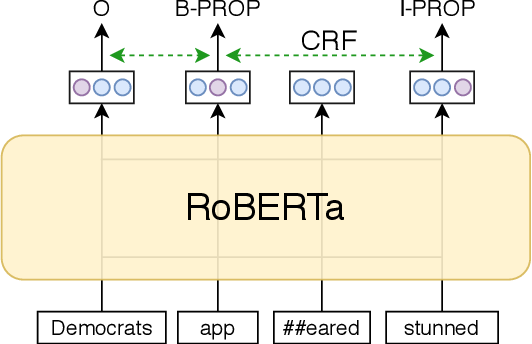

**RoBERTa** is an extension of BERT with changes to the pretraining procedure. The modifications include:

* training the model longer, with bigger batches, over more data
* removing the next sentence prediction objective
* training on longer sequences
* dynamically changing the masking pattern applied to the training data.
* The authors also collect a large new dataset **(CC-News)** of comparable size to other privately used datasets, to better control for training set size effects

In [35]:
import torch
from torch.optim import Adam
from tqdm import tqdm
from  sklearn.metrics import f1_score, roc_auc_score, accuracy_score

def train(model, train_dataloader, val_dataloader, learning_rate, epochs):
    best_val_loss = float('inf')
    early_stopping_threshold_count = 0
    EARLY_STOPPING = 3


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)
    criterion = criterion.to(device)

    model_metrics = {}
    model_metrics['train_accuracy'] = []
    model_metrics['val_accuracy'] = []
    model_metrics['train_loss'] = []
    model_metrics['val_loss'] = []
    model_metrics['f1'] = []
    model_metrics['val_f1'] = []
    model_metrics['auc'] = []
    model_metrics['val_auc'] = []


    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        total_f1_train = 0
        total_auc_train = 0

        model.train()

        for train_input, train_label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)

            train_label = train_label.to(device)

            output = model(input_ids, attention_mask)

            loss = criterion(output, train_label.float().unsqueeze(1))

            total_loss_train += loss.item()

            acc = ((output >= 0.5).int() == train_label.unsqueeze(1)).sum().item()
            total_acc_train += acc

            out_preds = output.cpu().detach().numpy().flatten()
            targets = train_label.cpu().detach().numpy().flatten()
            try:
              auc_score = roc_auc_score(targets, out_preds)
            except:
              auc_score = 1
            total_auc_train += auc_score

            out_preds[out_preds < 0.5] = 0
            out_preds[out_preds >= 0.5] = 1
            f1_score_ = f1_score(targets, out_preds)
            total_f1_train += f1_score_

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        with torch.no_grad():
            total_acc_val = 0
            total_loss_val = 0
            total_f1_val = 0
            total_auc_val = 0

            model.eval()

            for val_input, val_label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                val_label = val_label.to(device)

                output = model(input_ids, attention_mask)

                loss = criterion(output, val_label.float().unsqueeze(1))

                total_loss_val += loss.item()

                acc = ((output >= 0.5).int() == val_label.unsqueeze(1)).sum().item()
                total_acc_val += acc

                out_preds = output.cpu().detach().numpy().flatten()
                targets = val_label.cpu().detach().numpy().flatten()
                try:
                  auc_score = roc_auc_score(targets, out_preds)
                except:
                  auc_score = 1.
                total_auc_val += auc_score

                out_preds[out_preds < 0.5] = 0
                out_preds[out_preds >= 0.5] = 1
                f1_score_ = f1_score(targets, out_preds)
                total_f1_val += f1_score_


            print(f'Epochs: {epoch + 1} '
                  f'| Train Loss: {total_loss_train / len(train_dataloader): .3f} '
                  f'| Train Accuracy: {total_acc_train / (len(train_dataloader.dataset)): .3f} '
                  f'| Val Loss: {total_loss_val / len(val_dataloader): .3f} '
                  f'| Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
            model_metrics['train_accuracy'].append(total_acc_train / (len(train_dataloader.dataset)))
            model_metrics['val_accuracy'].append(total_acc_val / len(val_dataloader.dataset))
            model_metrics['train_loss'].append(total_loss_train / len(train_dataloader))
            model_metrics['val_loss'].append(total_loss_val / len(val_dataloader))
            model_metrics['f1'].append(total_f1_train / len(train_dataloader))
            model_metrics['val_f1'].append(total_f1_val / len(val_dataloader))
            model_metrics['auc'].append(total_auc_train / len(train_dataloader))
            model_metrics['val_auc'].append(total_auc_val / len(val_dataloader))

            print(model_metrics)

            if best_val_loss > total_loss_val:
                best_val_loss = total_loss_val
                torch.save(model, f"best_model.pt")
                print("Saved model")
                early_stopping_threshold_count = 0
            else:
                early_stopping_threshold_count += 1

            if early_stopping_threshold_count >= EARLY_STOPPING:
                print("Early stopping")
                break
    return model_metrics

In [36]:
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader

torch.manual_seed(0)
np.random.seed(0)


BERT_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
base_model = AutoModel.from_pretrained(BERT_MODEL)


model = SARCClassifier(base_model)


learning_rate = 1e-5
epochs = 10

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
metrics = train(model, train_dataloader, val_dataloader, learning_rate, epochs)

100%|██████████| 204/204 [00:14<00:00, 13.93it/s]


Epochs: 1 | Train Loss:  0.558 | Train Accuracy:  0.719 | Val Loss:  0.516 | Val Accuracy:  0.755
{'train_accuracy': [0.7194274028629857], 'val_accuracy': [0.7552147239263803], 'train_loss': [0.5579955282261948], 'val_loss': [0.5160684104205346], 'f1': [0.649048745372277], 'val_f1': [0.7319882731647439], 'auc': [0.8119718720821684], 'val_auc': [0.8385037348272643]}
Saved model


100%|██████████| 204/204 [00:14<00:00, 13.97it/s]


Epochs: 2 | Train Loss:  0.447 | Train Accuracy:  0.805 | Val Loss:  0.497 | Val Accuracy:  0.764
{'train_accuracy': [0.7194274028629857, 0.8051124744376278], 'val_accuracy': [0.7552147239263803, 0.7638036809815951], 'train_loss': [0.5579955282261948, 0.4474914630181065], 'val_loss': [0.5160684104205346, 0.4970998137312777], 'f1': [0.649048745372277, 0.7805522545718651], 'val_f1': [0.7319882731647439, 0.7412701677407562], 'auc': [0.8119718720821684, 0.8908846872082173], 'val_auc': [0.8385037348272643, 0.8689746732026146]}
Saved model


100%|██████████| 204/204 [00:14<00:00, 14.08it/s]


Epochs: 3 | Train Loss:  0.352 | Train Accuracy:  0.859 | Val Loss:  0.544 | Val Accuracy:  0.764
{'train_accuracy': [0.7194274028629857, 0.8051124744376278, 0.8588957055214724], 'val_accuracy': [0.7552147239263803, 0.7638036809815951, 0.7638036809815951], 'train_loss': [0.5579955282261948, 0.4474914630181065, 0.35219199478845387], 'val_loss': [0.5160684104205346, 0.4970998137312777, 0.5443001733362383], 'f1': [0.649048745372277, 0.7805522545718651, 0.8388467650722575], 'val_f1': [0.7319882731647439, 0.7412701677407562, 0.7499223271282093], 'auc': [0.8119718720821684, 0.8908846872082173, 0.9338420090258325], 'val_auc': [0.8385037348272643, 0.8689746732026146, 0.8541112278244635]}


100%|██████████| 204/204 [00:14<00:00, 14.11it/s]


Epochs: 4 | Train Loss:  0.260 | Train Accuracy:  0.901 | Val Loss:  0.632 | Val Accuracy:  0.761
{'train_accuracy': [0.7194274028629857, 0.8051124744376278, 0.8588957055214724, 0.9014314928425358], 'val_accuracy': [0.7552147239263803, 0.7638036809815951, 0.7638036809815951, 0.7613496932515338], 'train_loss': [0.5579955282261948, 0.4474914630181065, 0.35219199478845387, 0.25956966585838814], 'val_loss': [0.5160684104205346, 0.4970998137312777, 0.5443001733362383, 0.6323008590250039], 'f1': [0.649048745372277, 0.7805522545718651, 0.8388467650722575, 0.8791469605195114], 'val_f1': [0.7319882731647439, 0.7412701677407562, 0.7499223271282093, 0.7287838523132641], 'auc': [0.8119718720821684, 0.8908846872082173, 0.9338420090258325, 0.9606267507002804], 'val_auc': [0.8385037348272643, 0.8689746732026146, 0.8541112278244635, 0.8468749999999999]}


100%|██████████| 204/204 [00:14<00:00, 14.12it/s]

Epochs: 5 | Train Loss:  0.189 | Train Accuracy:  0.933 | Val Loss:  0.604 | Val Accuracy:  0.766
{'train_accuracy': [0.7194274028629857, 0.8051124744376278, 0.8588957055214724, 0.9014314928425358, 0.9333333333333333], 'val_accuracy': [0.7552147239263803, 0.7638036809815951, 0.7638036809815951, 0.7613496932515338, 0.7662576687116565], 'train_loss': [0.5579955282261948, 0.4474914630181065, 0.35219199478845387, 0.25956966585838814, 0.18916363349744406], 'val_loss': [0.5160684104205346, 0.4970998137312777, 0.5443001733362383, 0.6323008590250039, 0.6035306230552641], 'f1': [0.649048745372277, 0.7805522545718651, 0.8388467650722575, 0.8791469605195114, 0.9197410069959095], 'val_f1': [0.7319882731647439, 0.7412701677407562, 0.7499223271282093, 0.7287838523132641, 0.7429534245710715], 'auc': [0.8119718720821684, 0.8908846872082173, 0.9338420090258325, 0.9606267507002804, 0.9768343448490506], 'val_auc': [0.8385037348272643, 0.8689746732026146, 0.8541112278244635, 0.8468749999999999, 0.84548319

In [38]:
metrics

{'train_accuracy': [0.7194274028629857,
  0.8051124744376278,
  0.8588957055214724,
  0.9014314928425358,
  0.9333333333333333],
 'val_accuracy': [0.7552147239263803,
  0.7638036809815951,
  0.7638036809815951,
  0.7613496932515338,
  0.7662576687116565],
 'train_loss': [0.5579955282261948,
  0.4474914630181065,
  0.35219199478845387,
  0.25956966585838814,
  0.18916363349744406],
 'val_loss': [0.5160684104205346,
  0.4970998137312777,
  0.5443001733362383,
  0.6323008590250039,
  0.6035306230552641],
 'f1': [0.649048745372277,
  0.7805522545718651,
  0.8388467650722575,
  0.8791469605195114,
  0.9197410069959095],
 'val_f1': [0.7319882731647439,
  0.7412701677407562,
  0.7499223271282093,
  0.7287838523132641,
  0.7429534245710715],
 'auc': [0.8119718720821684,
  0.8908846872082173,
  0.9338420090258325,
  0.9606267507002804,
  0.9768343448490506],
 'val_auc': [0.8385037348272643,
  0.8689746732026146,
  0.8541112278244635,
  0.8468749999999999,
  0.8454831932773109]}

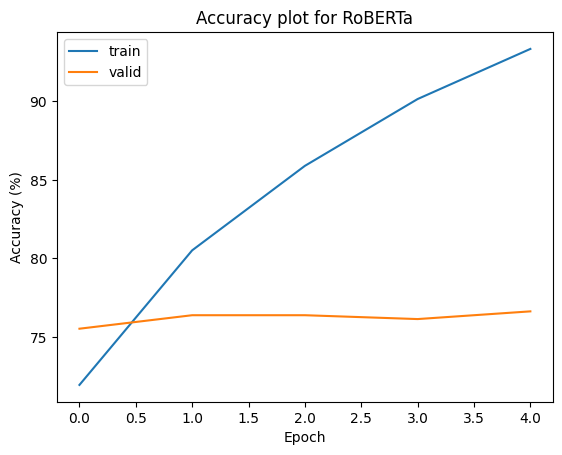

In [39]:
plt.plot(np.array(metrics['train_accuracy']) * 100.)
plt.plot(np.array(metrics['val_accuracy']) * 100.)
plt.legend(['train', 'valid'])
plt.title('Accuracy plot for RoBERTa')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

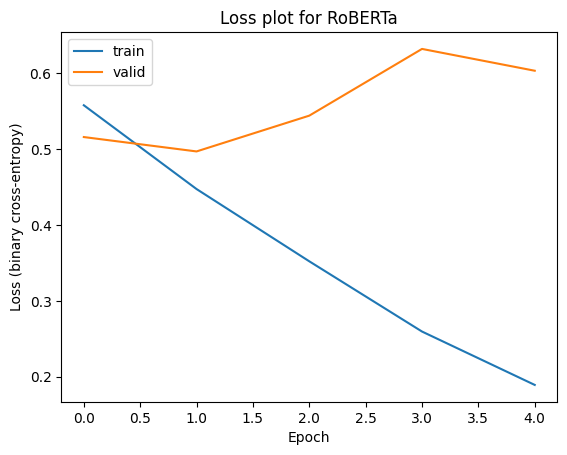

In [40]:
plt.plot(np.array(metrics['train_loss']))
plt.plot(np.array(metrics['val_loss']))
plt.legend(['train', 'valid'])
plt.title('Loss plot for RoBERTa')
plt.xlabel('Epoch')
plt.ylabel('Loss (binary cross-entropy)')
plt.show()

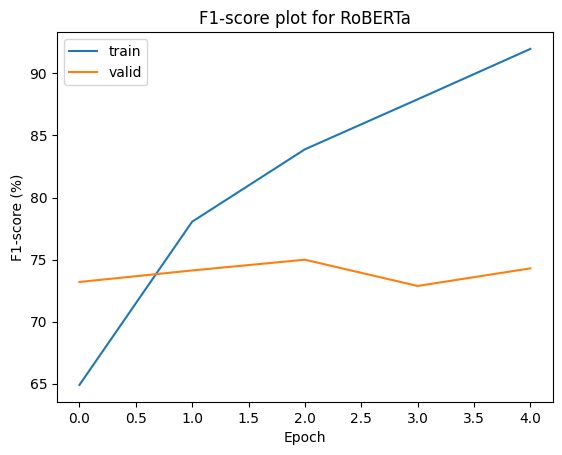

In [41]:
plt.plot(np.array(metrics['f1']) * 100)
plt.plot(np.array(metrics['val_f1']) * 100)
plt.legend(['train', 'valid'])
plt.title('F1-score plot for RoBERTa')
plt.xlabel('Epoch')
plt.ylabel('F1-score (%)')
plt.show()

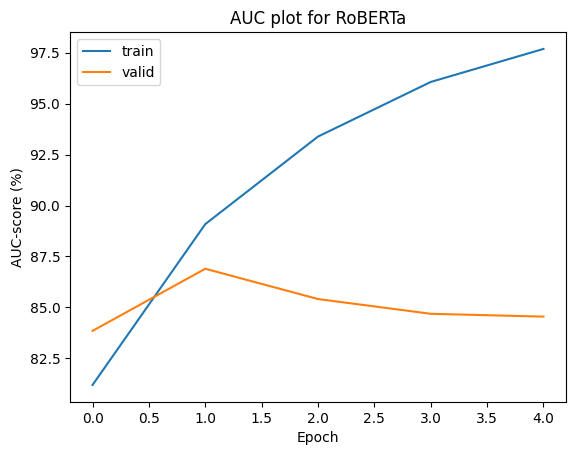

In [42]:
plt.plot(np.array(metrics['auc']) * 100)
plt.plot(np.array(metrics['val_auc']) * 100)
plt.legend(['train', 'valid'])
plt.title('AUC plot for RoBERTa')
plt.xlabel('Epoch')
plt.ylabel('AUC-score (%)')
plt.show()